## Importing the required libraries

In [2]:
!git clone -l -s -b master git://github.com/srgynmv/EmoteNN.git emotenn
%cd emotenn

Cloning into 'emotenn'...
remote: Enumerating objects: 297, done.
remote: Total 297 (delta 0), reused 0 (delta 0), pack-reused 297
Receiving objects: 100% (297/297), 486.98 KiB | 4.87 MiB/s, done.
Resolving deltas: 100% (172/172), done.
/content/emotenn


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from emotenn import constants as ct, train_utils as tu, load_utils as lu, plot_utils as pu

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Model

## Download and preprocess dataset

In [5]:
X, Y = lu.load_dataset(ct.RAVDESS)

# Normalize the dataset
X -= np.mean(X, axis=0)
X /= np.std(X, axis=0)
# Transform dimensions to the form of (count, timesteps, features)
X = np.swapaxes(X, 1, 2)

split = tu.split_dataset(X, Y, test_size=0.15, valid_size=0.2, align_by=128)
X_train, X_valid, X_test, Y_train, Y_valid, Y_test = split
print(f'Data dimensions: {X.shape}')

Data dimensions: (2452, 216, 13)


## Initialize utility functions and variables

In [0]:
def display_results(model, history):
    for name, x, y in [('Train', X_train, Y_train), ('Validation', X_valid, Y_valid), ('Test', X_test, Y_test)]:
        score = model.evaluate(x, y)
        print("{} dataset {}: {:.2f}%".format(name, model.metrics_names[1], score[1] * 100))
    pu.plot_model_history(history.history)

def train(model, batch_size=64, epochs=300):
    return model.fit(X_train, 
                     Y_train, 
                     batch_size=batch_size, 
                     epochs=epochs, 
                     validation_data=(X_valid, Y_valid),
                     shuffle=True)

In [0]:
strategy = tu.get_distribution_strategy()

## First LSTM model

In [0]:
def build_lstm(hidden_nodes, optimizer, dropout=0.2):
    with strategy.scope():
        model = Sequential()
        model.add(LSTM(hidden_nodes, dropout=dropout, input_shape=X.shape[1:]))
        model.add(Dense(7, activation='softmax'))
        model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
        return model

In [0]:
optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
model1 = build_lstm(200, optimizer)
model1_history = train(model1, batch_size=128, epochs=200)

48/48 [==============================] - 0s 7ms/step - accuracy: 1.0000 - loss: 0.0032
Train dataset accuracy: 100.00%
17/17 [==============================] - 0s 21ms/step - accuracy: 0.7380 - loss: 1.3142
Validation dataset accuracy: 73.80%
13/13 [==============================] - 0s 25ms/step - accuracy: 0.7455 - loss: 1.2532
Test dataset accuracy: 74.55%


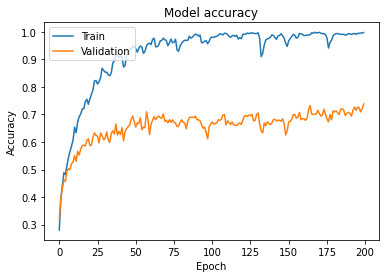

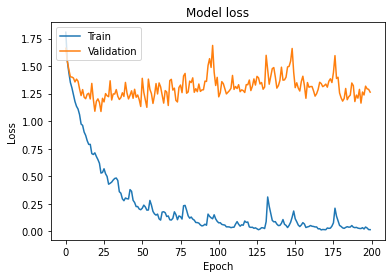

In [10]:
display_results(model1, model1_history)